Suspicious Web Traffic Detection: A Data Science Approach to Cyber Threat Analysis

Step 1: Data Import and Basic Overview

In [20]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score



In [2]:
#Load dataset

data=pd.read_csv(r"C:\Users\akhil\Documents\Data analysis\DA Assignment (Unified Mentor)\Projects\Project 3\CloudWatch_Traffic_Web_Attack.csv")

In [3]:
#View basic information

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes: int64

In [4]:
#Display the first few rows of the dataset

print(data.head())

   bytes_in  bytes_out         creation_time              end_time  \
0      5602      12990  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
1     30912      18186  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
2     28506      13468  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
3     30546      14278  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
4      6526      13892  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   

            src_ip src_ip_country_code protocol  response.code  dst_port  \
0   147.161.161.82                  AE    HTTPS            200       443   
1     165.225.33.6                  US    HTTPS            200       443   
2  165.225.212.255                  CA    HTTPS            200       443   
3   136.226.64.114                  US    HTTPS            200       443   
4   165.225.240.79                  NL    HTTPS            200       443   

         dst_ip              rule_names                      observation_name  \
0  10.138.69.97  Suspicious Web Traffic  

Step 2: Data Preprocessing


In [5]:
#Check for missing values

print(data.isnull().sum())

bytes_in               0
bytes_out              0
creation_time          0
end_time               0
src_ip                 0
src_ip_country_code    0
protocol               0
response.code          0
dst_port               0
dst_ip                 0
rule_names             0
observation_name       0
source.meta            0
source.name            0
time                   0
detection_types        0
dtype: int64


In [6]:
#Check for Duplicates

data.drop_duplicates(inplace=True)

In [8]:
# Convert timestamps
for col in ['creation_time', 'end_time', 'time']:
    data[col] = pd.to_datetime(data[col], errors='coerce')

Step 3: Feature Engineering

In [10]:
# Session Duration
data['session_duration'] = (data['end_time'] - data['creation_time']).dt.total_seconds()

In [16]:
#Bytes ratio
if 'bytes_in' in data.columns and 'bytes_out' in data.columns:
    data['bytes_ratio'] = data['bytes_out'].astype(float) / (data['bytes_in'].astype(float) + 1)
else:
    data['bytes_ratio'] = 0  # fallback in case columns are missing


In [11]:
# Hour of day
data['hour'] = data['time'].dt.hour

In [12]:
# Flag suspicious traffic
data['is_suspicious'] = data['rule_names'].notnull().astype(int)

In [13]:
#Label encoding categorical features
categorical_cols = ['protocol', 'src_ip_country_code']
le = LabelEncoder()
for col in categorical_cols:
    data[col] = le.fit_transform(data[col].astype(str))

 MODULE 1: Security Analysis (EDA)

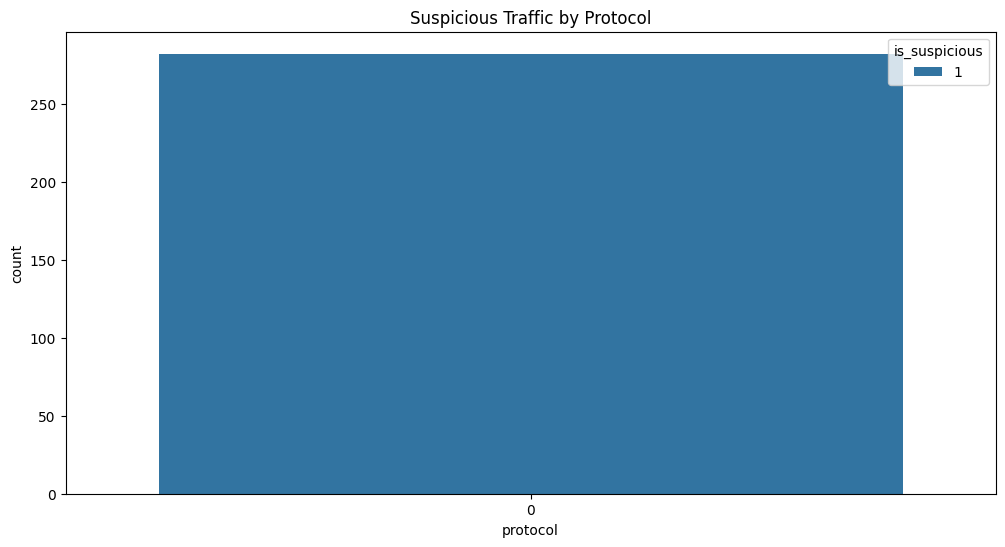

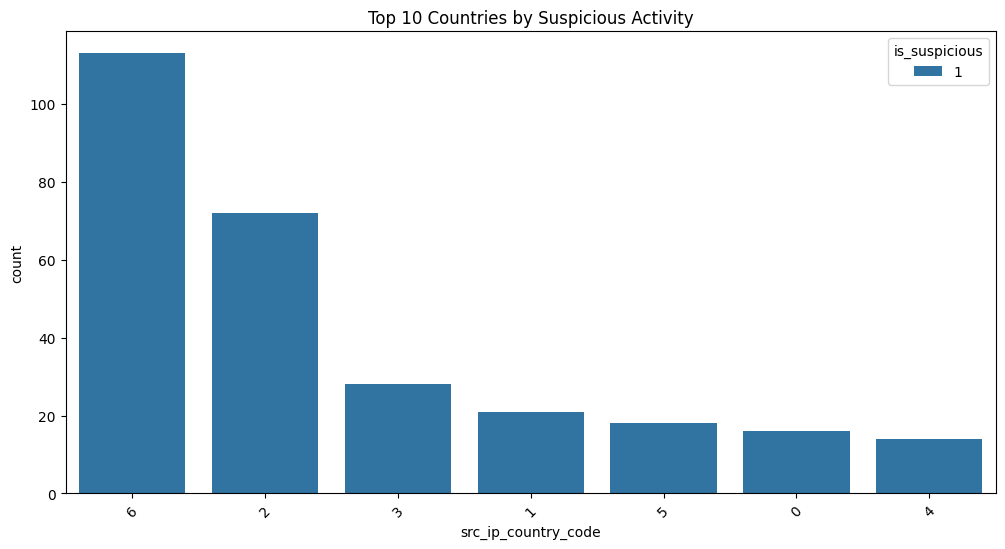

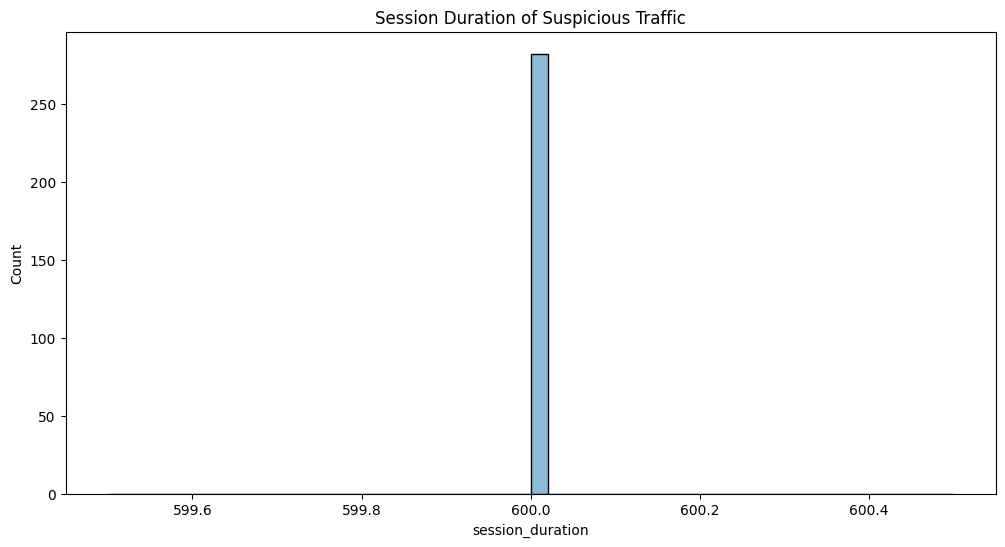

In [14]:
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='protocol', hue='is_suspicious')
plt.title('Suspicious Traffic by Protocol')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='src_ip_country_code', order=data['src_ip_country_code'].value_counts().index[:10], hue='is_suspicious')
plt.title('Top 10 Countries by Suspicious Activity')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data[data['is_suspicious'] == 1]['session_duration'], bins=50, kde=True)
plt.title('Session Duration of Suspicious Traffic')
plt.show()

MODULE 2: Classification Model (Random Forest)

In [21]:
features = ['bytes_in', 'bytes_out', 'session_duration', 'bytes_ratio', 'hour', 'protocol', 'src_ip_country_code']
X = data[features].fillna(0)
y = data['is_suspicious']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Random Forest Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        57

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57


Confusion Matrix:
[[57]]


C:\Users\akhil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


MODULE 3: Anomaly Detection (Isolation Forest)

In [23]:
anomaly_features = ['bytes_in', 'bytes_out', 'session_duration', 'bytes_ratio', 'hour']
iso = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
data['anomaly_score'] = iso.fit_predict(data[anomaly_features].fillna(0))

# -1 = Anomaly, 1 = Normal
data['is_anomaly'] = (data['anomaly_score'] == -1).astype(int)
print("\nAnomalies Detected:", data['is_anomaly'].sum())



Anomalies Detected: 3


In [24]:
print("\nAnomalous Records:")
print(data[data['is_anomaly'] == 1])



Anomalous Records:
     bytes_in  bytes_out             creation_time                  end_time  \
31         80        528 2024-04-25 23:20:00+00:00 2024-04-25 23:30:00+00:00   
36    4190330     283456 2024-04-25 23:30:00+00:00 2024-04-25 23:40:00+00:00   
257  24326941    1529035 2024-04-26 09:30:00+00:00 2024-04-26 09:40:00+00:00   

             src_ip  src_ip_country_code  protocol  response.code  dst_port  \
31   192.241.230.19                    6         0            200       443   
36    155.91.45.242                    6         0            200       443   
257   155.91.45.242                    6         0            200       443   

           dst_ip  ...   source.meta     source.name  \
31   10.138.69.97  ...  AWS_VPC_Flow  prod_webserver   
36   10.138.69.97  ...  AWS_VPC_Flow  prod_webserver   
257  10.138.69.97  ...  AWS_VPC_Flow  prod_webserver   

                         time detection_types session_duration hour  \
31  2024-04-25 23:20:00+00:00        waf_rule 

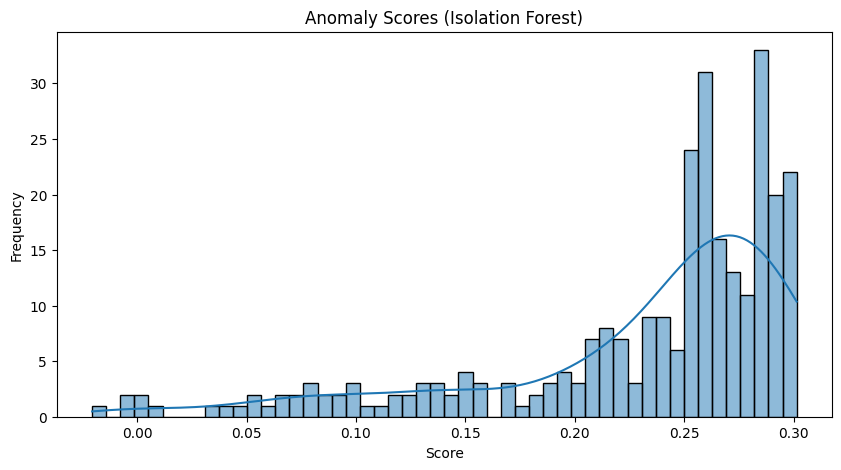

In [25]:
#Anomoly score histogram

plt.figure(figsize=(10, 5))
sns.histplot(iso.decision_function(data[anomaly_features].fillna(0)), bins=50, kde=True)
plt.title('Anomaly Scores (Isolation Forest)')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


Final Visualization: Suspicious Traffic Over Time

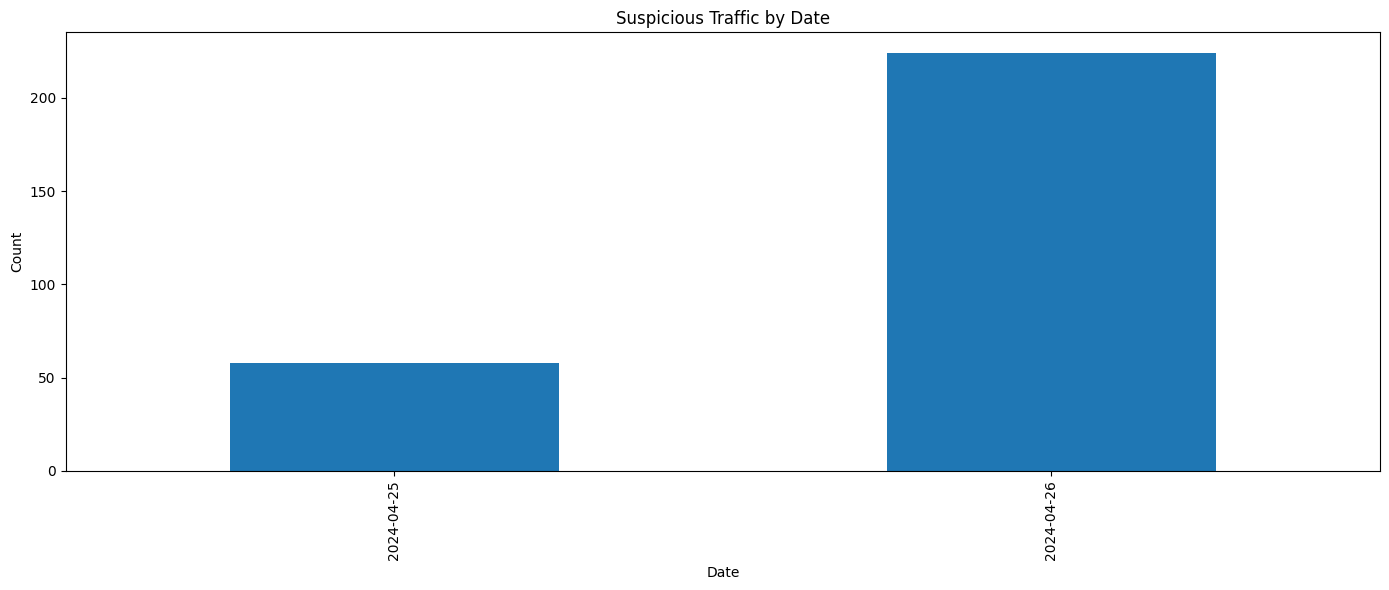

In [26]:
data['date'] = data['time'].dt.date
suspicious_by_day = data[data['is_suspicious'] == 1].groupby('date').size()
suspicious_by_day.plot(kind='bar', figsize=(14,6), title='Suspicious Traffic by Date')
plt.ylabel('Count')
plt.xlabel('Date')
plt.tight_layout()
plt.show()